In [1]:
# module imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import os

In [2]:
# Outlier Function
def remove_outliers(df, k):
    # List of outlier indices
    outlier_indices = []

    # Iterate through columns in dataframe
    for col in df.columns.tolist():
        # Find the 25% quantile
        Q1 = df[col].quantile(0.25)
        # Find the 75% quantile
        Q3 = df[col].quantile(0.75)
        # Find IQR
        IQR = Q3 - Q1
        # Determine outliers based off of IQR, Q1 and Q3
        outlier_list_col = df[(df[col] < Q1 - k * IQR) | (df[col] > Q3 + k * IQR)].index
        # Add outliers to list
        outlier_indices.extend(outlier_list_col)

    # Return dataframe without outliers
    return df.drop(list(set(outlier_indices)))

# Normalization function
def normalize(dataframe, cols_to_exclude = [], fit=False):
    # If fit and columns to exclude then...
    if fit and cols_to_exclude:
        # Drop columns to exclude
        df2 = dataframe.drop(cols_to_exclude, axis=1)
        # Fit dataframe
        scaler.fit(df2)
    elif fit:
        # fit dataframe if fit is true
        scaler.fit(dataframe)
    elif cols_to_exclude:
        # drop columns to exclude
        df2 = dataframe.drop(cols_to_exclude, axis=1)
        # store excluded columns into a different dataframe
        df3 = dataframe[cols_to_exclude]
        # transform df2 according to fitted scalar
        df2 = pd.DataFrame(scaler.transform(df2), columns=df2.columns)
        # combine both dataframes back together
        return concat([df2.reset_index(drop=True), df3.reset_index(drop=True)], axis=1)
    else:
        # transform dataframe according to fitted scalar
        return pd.DataFrame(scaler.transform(dataframe), columns=dataframe.columns).reset_index(drop=True)


scaler = MinMaxScaler()

In [3]:
# Find all files in the "Clean Datasets" folder that is csv
files = Path('./Clean Datasets/top_30').glob('*.csv')
# Initiate blank dataframe
df = pd.DataFrame()
# Number of years to predict
pred_years = 4
# Define target class
target = 'Total Disasters'
# Define other target classes
other_target_classes = ['Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Wildfire']

# Iterate through all found csvs from clean datasets folder
for file in files:
    # read csv file
    curr_df = pd.read_csv(file)

    # Fix column names to add meaning to the column names
    if os.path.basename(file) == 'country_sea_levels.csv':
        curr_df.rename(columns={'Value': 'Sea Level'}, inplace=True)
    elif os.path.basename(file) == 'climate_disasters_clean.csv':
        curr_df.rename(columns={'TOTAL': 'Total Disasters'}, inplace=True)

    # check if dataframe is empty
    if df.empty:
        # set dataframe to current dataframe
        df = curr_df
    else:
        # merge dataframe on Year bind as inner
        df = df.merge(curr_df, on=['Year', 'Country'], how='inner')

# Find all string columns
column_names = [col for col in df.columns if all(isinstance(val, str) for val in df[col].dropna())]
# Initiate label encoder for string columns
label_encoder = LabelEncoder()

# Iterate each column that is string
for column_name in column_names:
    # Ensure column is in dataframe
    if column_name in df.columns.tolist():
        # Fill na as Unknown
        df[column_name] = df[column_name].fillna('Unknown')
        # Encode column with labels
        df[column_name] = label_encoder.fit_transform(df[column_name]) + 1
        # Cast labels as integer data type
        df[column_name] = df[column_name].astype(int)

# Sort dataframe by country, year
df.sort_values(['Country', 'Year'], inplace=True)
# Shift label x number of years for prediction
df[target] = df[target].shift(-pred_years)
# Drop bias columns that is part of the target predictor TOTAL
if other_target_classes:
    df.drop(columns=other_target_classes, inplace=True)
# Replace NAs with the mean of the column
df.fillna(df.mean(), inplace=True)
# Drop blank rows
df.dropna(how='all', inplace=True)
# Drop columns with all identical values
df = df.loc[:, (df.nunique(dropna=False) != 1)]
# Drop duplicate rows
df.drop_duplicates(inplace=True)

df.to_csv('./complete_dataset.csv', index=False)
# describe dataframe
df.describe()


,Year,Country,Total Disasters,Sea Level,Carbon stocks in forests,Forest area,Index of carbon stocks in forests,Index of forest extent,Land area,Share of forest area,...,Inland water bodies: Climate regulating,Mangroves: Climate regulating,Permanent snow and glaciers: Climate regulating,Shrub-covered areas: Climate regulating,"Shrubs and/or herbaceous vegetation, aquatic or regularly flooded: Climate regulating",Sparsely natural vegetated areas: Climate neutral,Terrestrial barren land: Climate neutral,Tree-covered areas: Climate regulating,Woody crops: Climate regulating,Temperature
count,899.000000,899.000000,899.000000,899.000000,899.000000,8.990000e+02,899.000000,899.000000,8.990000e+02,899.000000,...,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000,899.000000
mean,2006.000000,16.000000,5.931844,20.953521,15806.356041,2.269736e+05,110.768565,101.163712,6.776014e+05,33.112809,...,8080.731073,378.907788,1310.222032,35216.145315,4802.546041,21189.603268,15890.393336,99558.170899,4400.815344,0.861057
std,8.371257,8.949251,6.045746,28.114102,52305.939520,7.347873e+05,29.579975,10.359049,2.286172e+06,18.956452,...,20653.203045,826.288934,3575.740431,55875.009722,14877.845482,55211.653712,34847.812732,194301.785281,6440.255105,0.511661
min,1992.000000,1.000000,0.000000,-57.510000,19.004300,3.473000e+02,76.168056,76.168044,2.756000e+03,1.852782,...,30.513500,0.000000,0.000000,42.569600,0.000000,0.589000,0.000000,419.359300,46.196100,-0.757000
25%,1999.000000,8.000000,2.000000,-1.042623,583.021400,6.487250e+03,97.648513,96.371980,2.981700e+04,14.752472,...,440.786500,0.000000,0.000000,1325.154000,13.148600,31.145100,18.391800,5388.472850,498.448250,0.496000
50%,2006.000000,16.000000,4.000000,16.351915,1665.456800,1.917950e+04,100.000000,99.792262,7.708800e+04,33.081594,...,953.969800,19.577600,0.000000,6812.568100,163.053600,515.303100,507.366600,14150.517900,2005.497200,0.820000
75%,2013.000000,24.000000,7.000000,43.089222,8288.176700,9.641729e+04,116.786425,102.934800,2.973190e+05,49.399566,...,4840.490500,376.126598,488.215300,52332.492400,3109.648200,11618.073850,18229.542300,81986.488750,5153.836600,1.183500
max,2020.000000,31.000000,34.000000,123.380000,296948.829100,4.220757e+06,345.808955,148.546379,1.302696e+07,69.553288,...,104025.000000,4117.394400,18314.800000,202541.915200,87681.500000,284361.000000,172636.364200,955922.993800,32056.761900,3.691000


In [4]:
df_clean = remove_outliers(df, k=1.2)
print(f'Removed {df.shape[0] - df_clean.shape[0]} outliers')
# df_clean = df

Removed 608 outliers


In [5]:
# Define test data size and seed_value for experiments
test_size = 0.3
seed_value = 42

# Find unique years and sort list
years = df_clean['Year'].unique()
years.sort()

# Find year cutoff for train/test according to test size
index_cutoff = int(len(years) * (1 - test_size))

# Split train eda and test cda data by making last year as test dataset and rest and training dataset
train_eda_df = df_clean[df_clean['Year'].isin(years[:index_cutoff])].reset_index()
test_cda_df = df_clean[df_clean['Year'].isin(years[index_cutoff:])].reset_index()

# Split train eda and test cda into train and test datasets
x_train = train_eda_df.drop([target, 'Year'], axis=1)
y_train = train_eda_df[target]
x_test = test_cda_df.drop([target, 'Year'], axis=1)
y_test = test_cda_df[target]

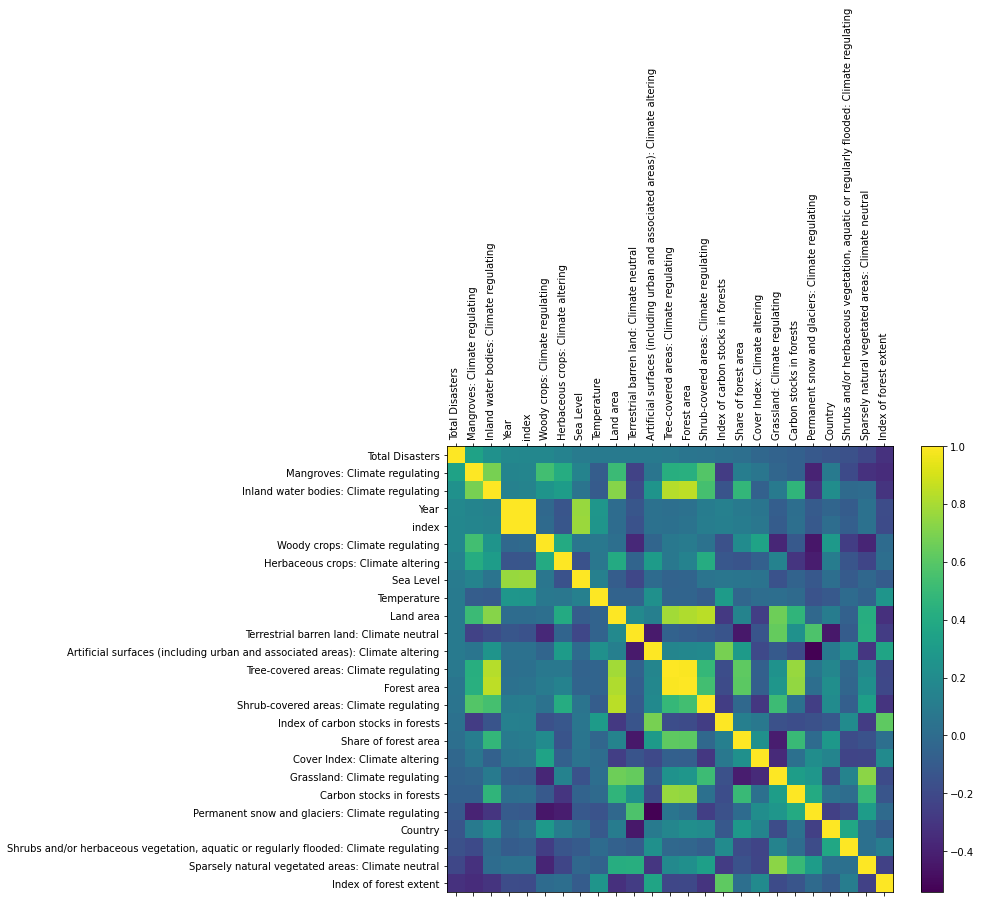

In [6]:
# import visual package matplotlib
import matplotlib.pyplot as plt

# Find top 30 correlated features to the predictor TOTAL and get the column names
corr_cols = train_eda_df.corr().loc[:,[target]].dropna().sort_values(by=[target], ascending=False, axis=0).head(31).T.columns.tolist()

# Plot correlation of the top 30 correlated features including TOTAL
plt.figure(figsize=(10, 8))
plt.matshow(train_eda_df.loc[:, corr_cols].corr(), fignum=1)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)

plt.colorbar()
plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_28132\2937998196.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


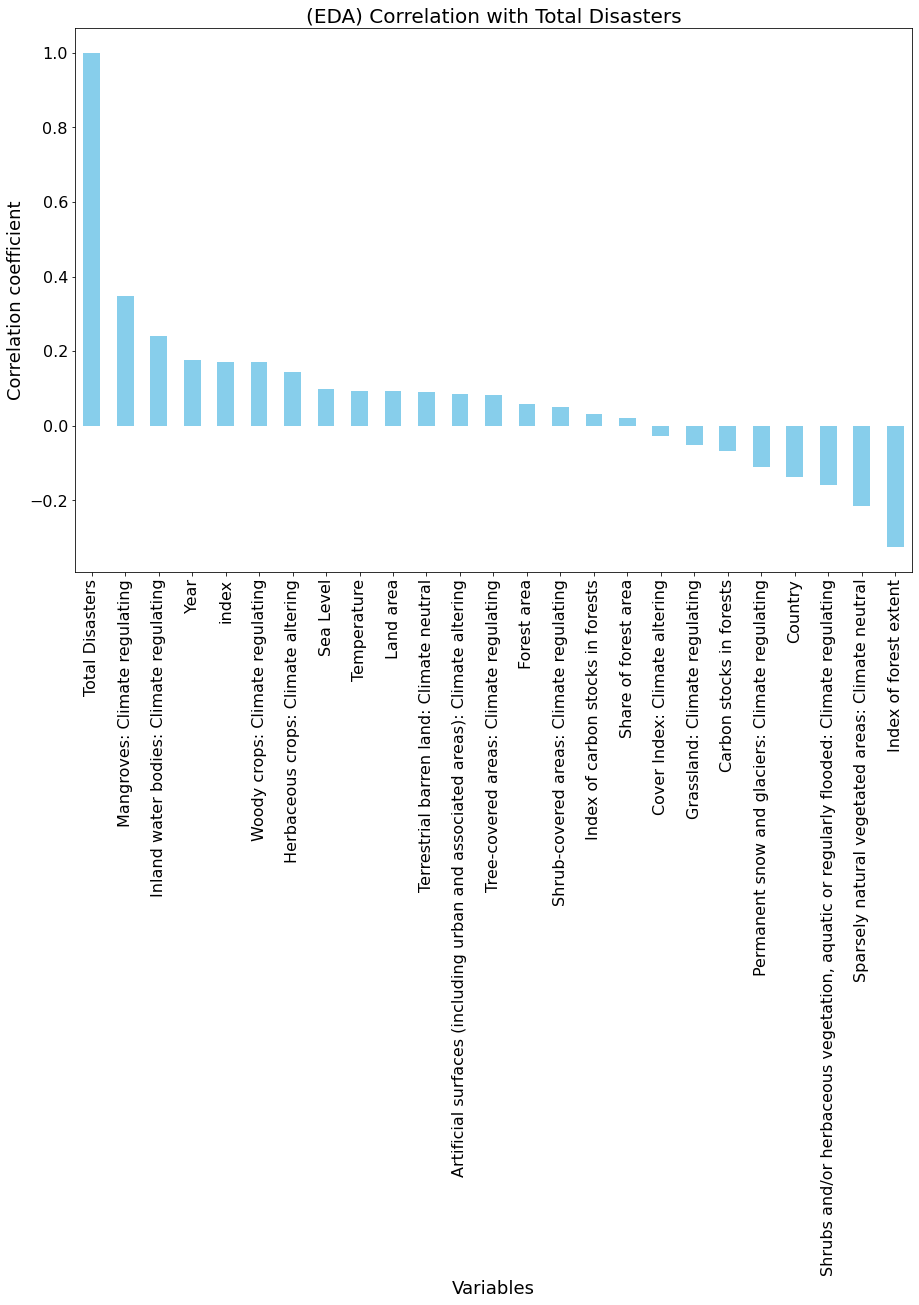

In [7]:
# Find best correlated features
best_feats = train_eda_df.corr().sort_values(by=[target], ascending=False, axis=0)[target]

# Display best features as bar graph
plt.rcParams.update({'font.size': 14}) 
plt.figure(figsize=(15, 10))
best_feats.plot(kind='bar', color='skyblue')
plt.title(f'(EDA) Correlation with {target}', fontsize=20)
plt.xlabel('Variables', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('./images/corr_plot.png', dpi=300, bbox_inches='tight')
plt.show()

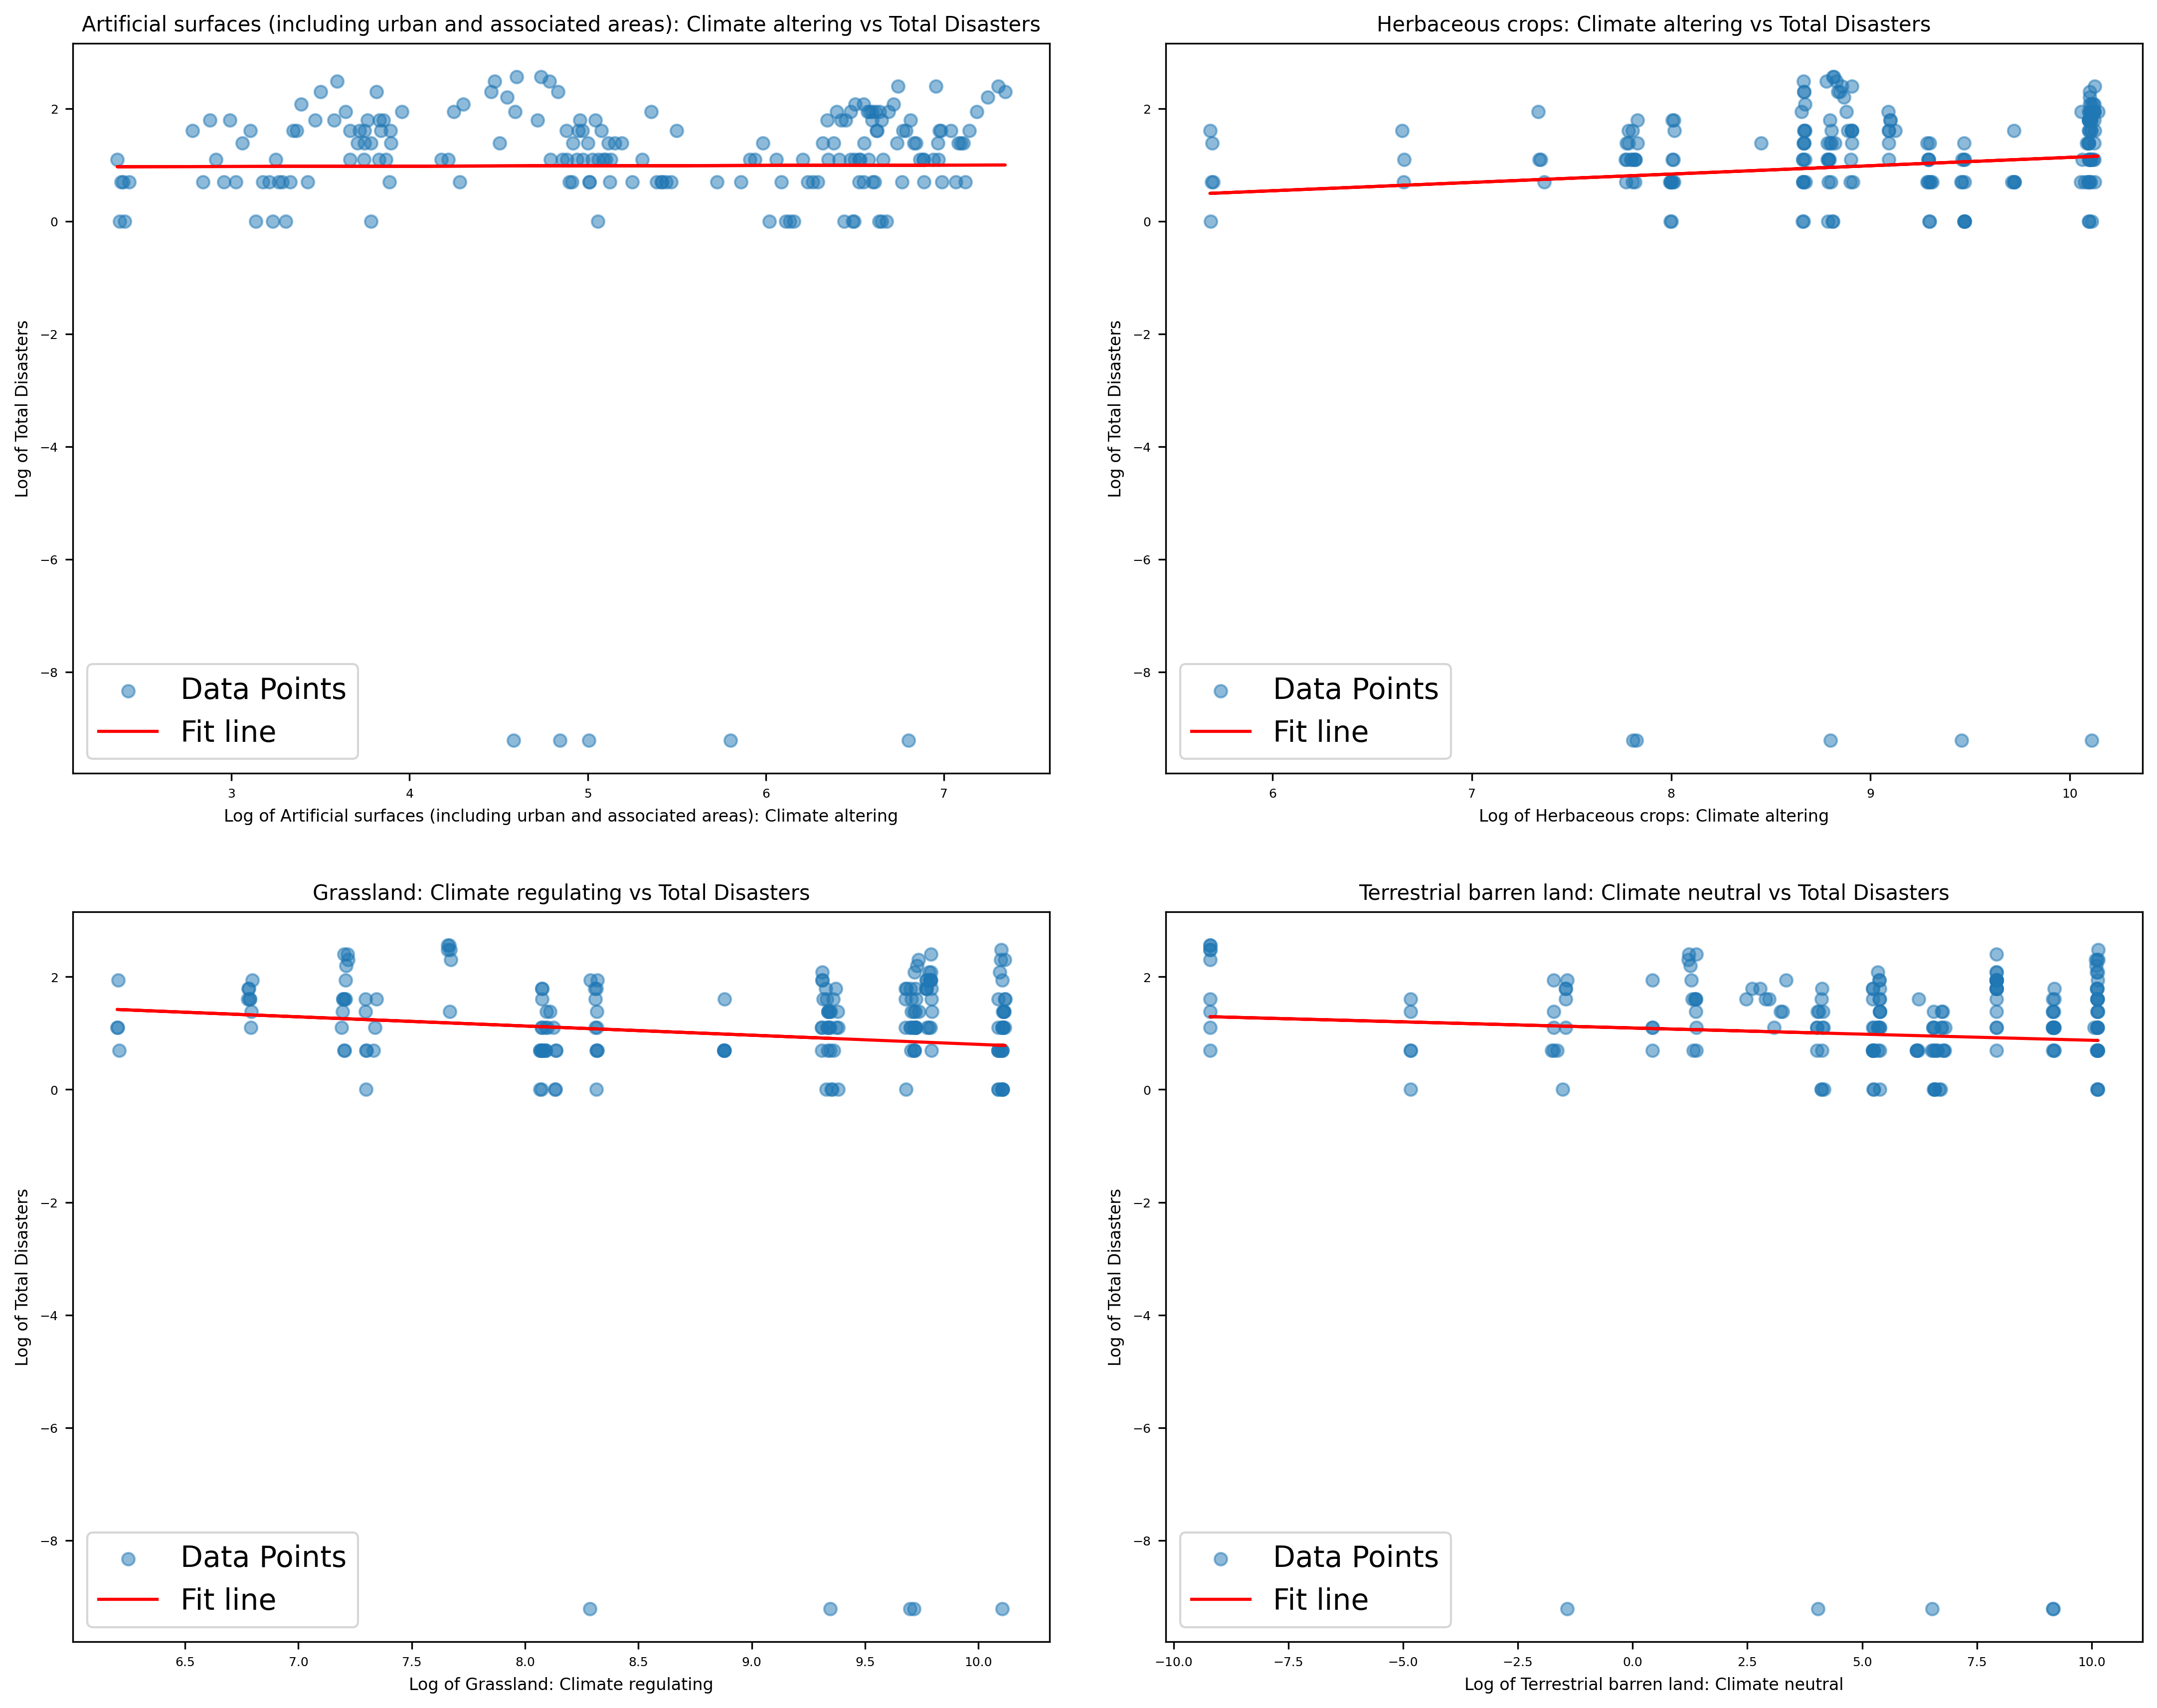

In [8]:
# Define features to plot in relation to predictor
variables = [
    'Artificial surfaces (including urban and associated areas): Climate altering',
    'Herbaceous crops: Climate altering',
    'Grassland: Climate regulating',
    'Terrestrial barren land: Climate neutral'
]

# copy dataframe that is not label
df_copy = train_eda_df[[col for col in train_eda_df.columns if target not in col or col == target]].copy()
# create plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
axes = axes.flatten()
epsilon = 1e-4
title_fontsize = 10
label_fontsize = 8
tick_labelsize = 6
# transform label with log
df_copy[target] = np.log(df_copy[target] + epsilon)

# Iterate through features
for i, var_x in enumerate(variables):
    # transform feature with log
    df_copy[var_x] = np.log(df_copy[var_x] + epsilon)

    try:
        # Attempt line prediction fit of data
        m, b = np.polyfit(df_copy[var_x], df_copy[target], 1)
        y_hat = m * df_copy[var_x] + b
    except:
        # If error return y_hat as none
        y_hat = None
        pass

    # Plot scatter graph
    axes[i].scatter(df_copy[var_x], df_copy[target], alpha=0.5, label='Data Points')
    
    if y_hat is not None:
        # Add prediction line if y_hat is defined
        axes[i].plot(df_copy[var_x], y_hat, color='red', label='Fit line')

    # Adjust the title and labels with the new font size
    axes[i].set_title(f'{var_x} vs {target}', fontsize=title_fontsize)
    axes[i].set_xlabel(f'Log of {var_x}', fontsize=label_fontsize)
    axes[i].set_ylabel(f'Log of {target}', fontsize=label_fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=tick_labelsize)
    axes[i].legend()

# Save graph
plt.tight_layout(pad=2.0)
plt.savefig('./images/eda_graph.png', bbox_inches='tight')

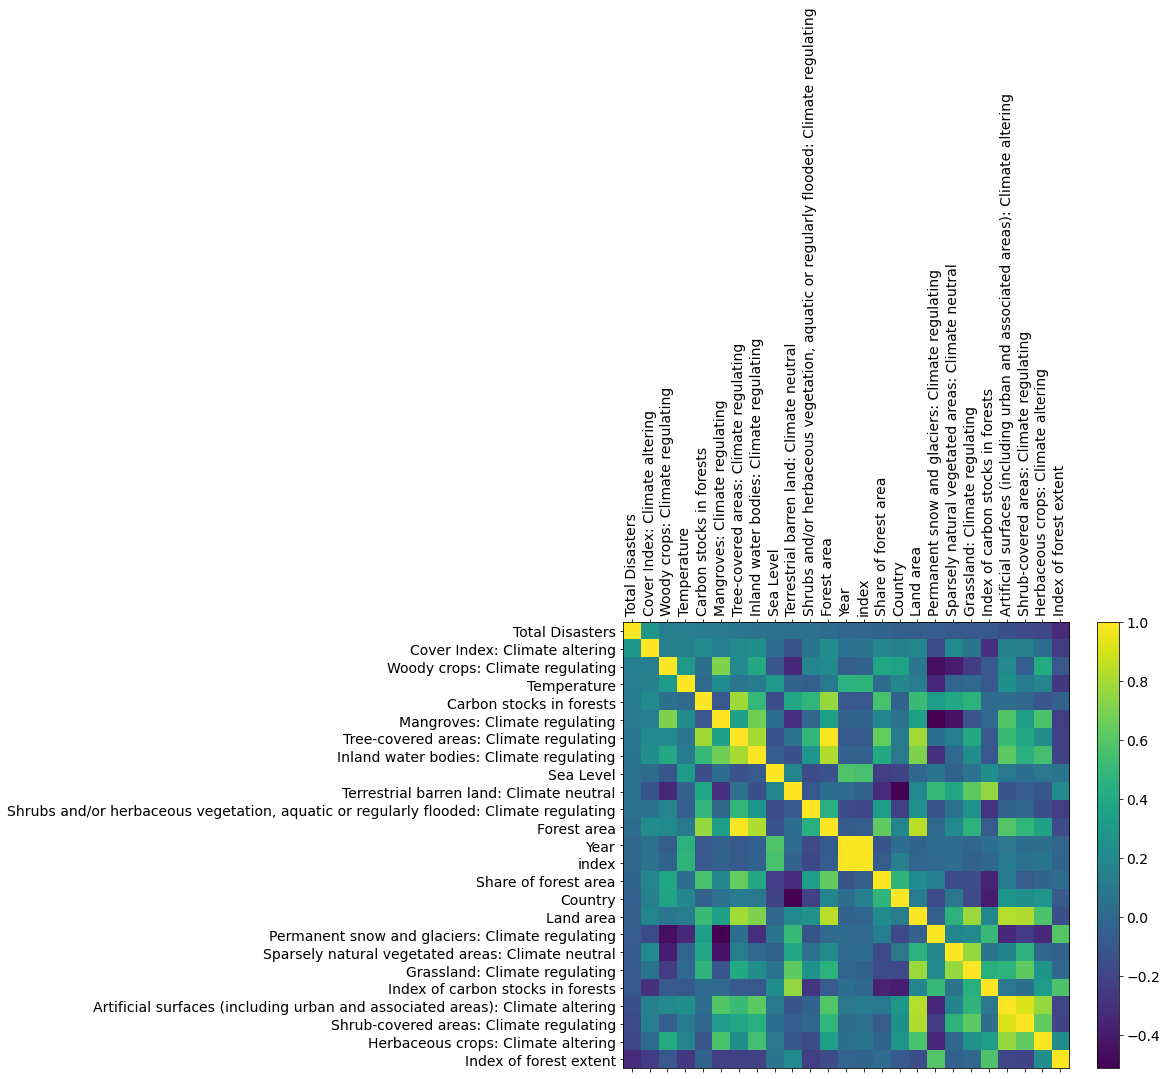

In [9]:
# import visual package matplotlib
import matplotlib.pyplot as plt

# Find top 30 correlated features to the predictor TOTAL and get the column names
corr_cols = test_cda_df.corr().loc[:,[target]].dropna().sort_values(by=[target], ascending=False, axis=0).head(31).T.columns.tolist()

# Plot correlation of the top 30 correlated features including TOTAL
plt.figure(figsize=(10, 8))
plt.matshow(test_cda_df.loc[:, corr_cols].corr(), fignum=1)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)

plt.colorbar()
plt.show()

C:\Users\kevin\AppData\Local\Temp\ipykernel_28132\4087393017.py:13: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


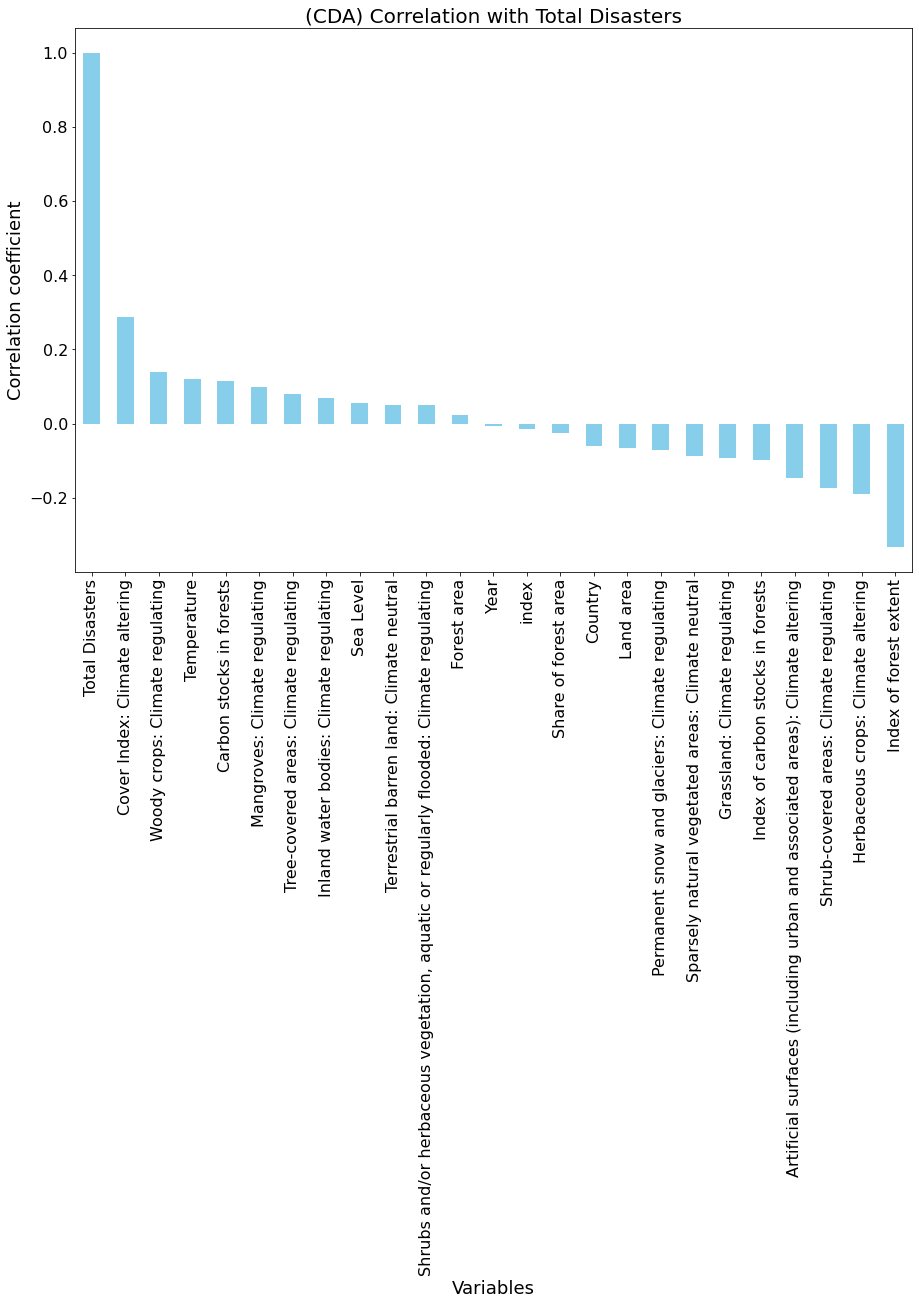

In [10]:
# Find best correlated features
best_feats = test_cda_df.corr().sort_values(by=[target], ascending=False, axis=0)[target]

# Display best features as bar graph
plt.rcParams.update({'font.size': 14}) 
plt.figure(figsize=(15, 10))
best_feats.plot(kind='bar', color='skyblue')
plt.title(f'(CDA) Correlation with {target}', fontsize=20)
plt.xlabel('Variables', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)
plt.xticks(rotation=90, fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('./images/corr_plot.png', dpi=300, bbox_inches='tight')
plt.show()

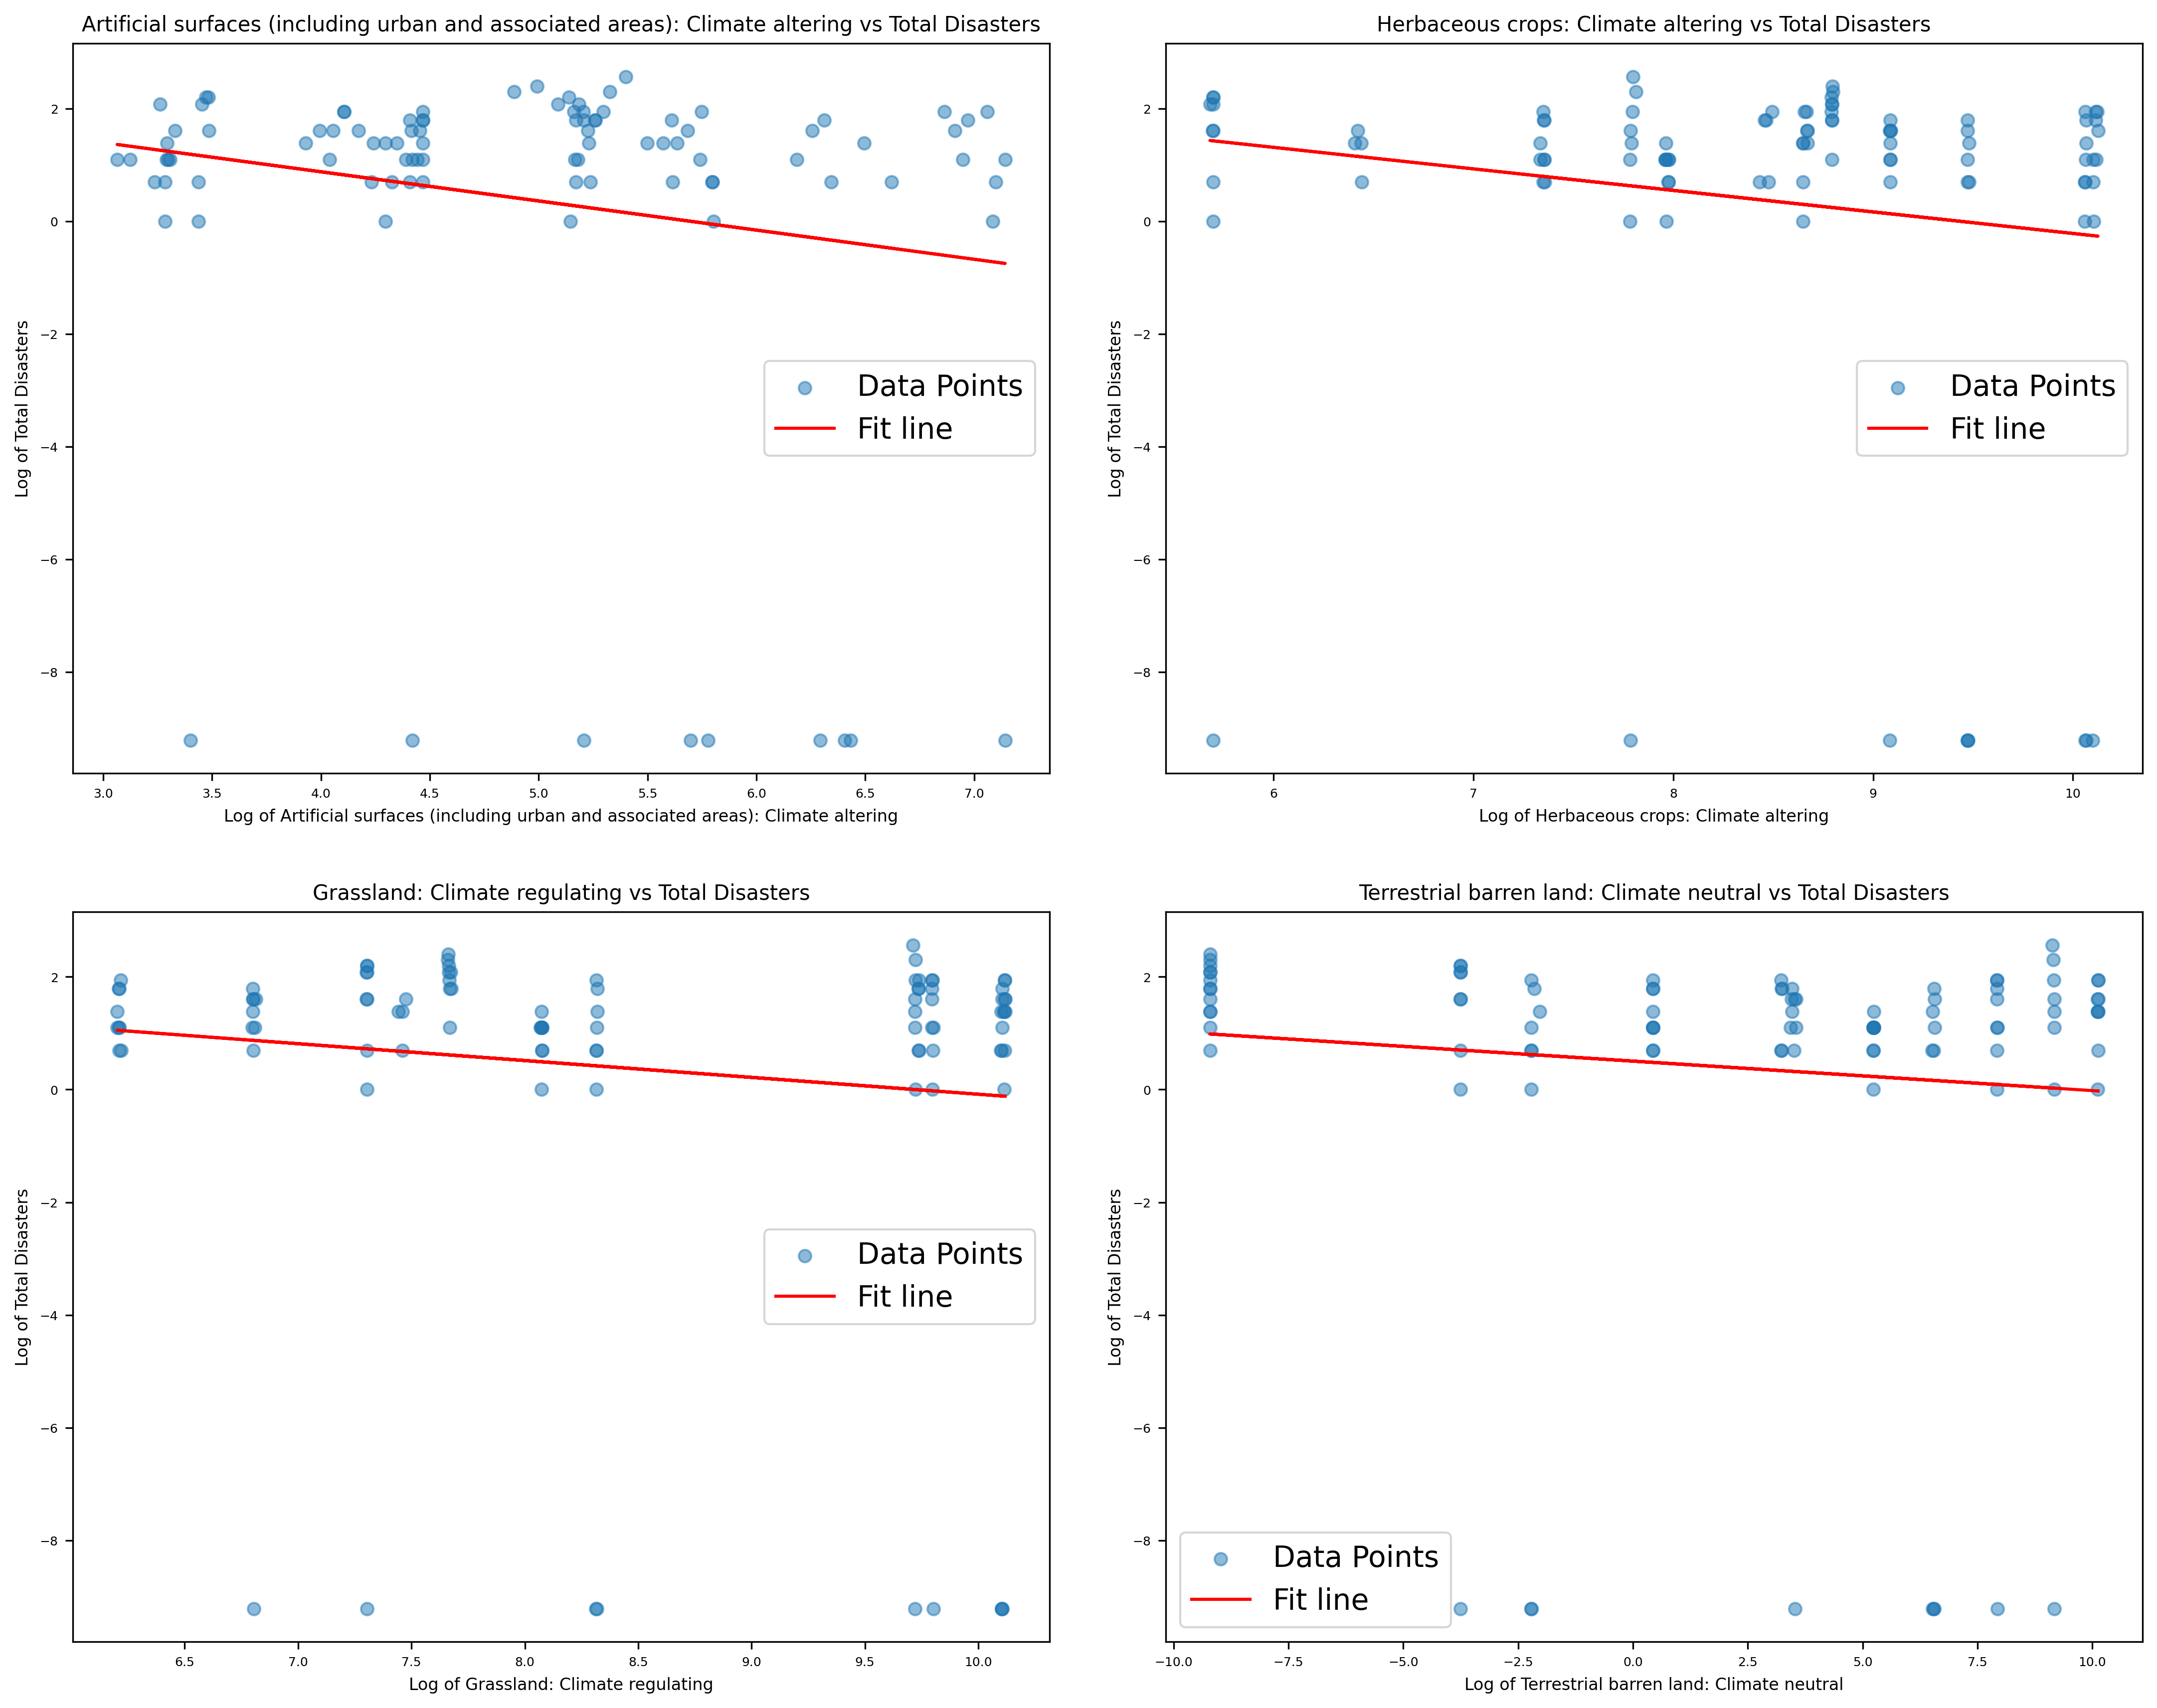

In [11]:
# Define features to plot in relation to predictor
variables = [
    'Artificial surfaces (including urban and associated areas): Climate altering',
    'Herbaceous crops: Climate altering',
    'Grassland: Climate regulating',
    'Terrestrial barren land: Climate neutral'
]

# copy dataframe that is not label
df_copy = test_cda_df[[col for col in train_eda_df.columns if target not in col or col == target]].copy()
# create plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12), dpi=300)
axes = axes.flatten()
epsilon = 1e-4
title_fontsize = 10
label_fontsize = 8
tick_labelsize = 6
# transform label with log
df_copy[target] = np.log(df_copy[target] + epsilon)

# Iterate through features
for i, var_x in enumerate(variables):
    # transform feature with log
    df_copy[var_x] = np.log(df_copy[var_x] + epsilon)

    try:
        # Attempt line prediction fit of data
        m, b = np.polyfit(df_copy[var_x], df_copy[target], 1)
        y_hat = m * df_copy[var_x] + b
    except:
        # If error return y_hat as none
        y_hat = None
        pass

    # Plot scatter graph
    axes[i].scatter(df_copy[var_x], df_copy[target], alpha=0.5, label='Data Points')
    
    if y_hat is not None:
        # Add prediction line if y_hat is defined
        axes[i].plot(df_copy[var_x], y_hat, color='red', label='Fit line')

    # Adjust the title and labels with the new font size
    axes[i].set_title(f'{var_x} vs {target}', fontsize=title_fontsize)
    axes[i].set_xlabel(f'Log of {var_x}', fontsize=label_fontsize)
    axes[i].set_ylabel(f'Log of {target}', fontsize=label_fontsize)
    axes[i].tick_params(axis='both', which='major', labelsize=tick_labelsize)
    axes[i].legend()

# Save graph
plt.tight_layout(pad=2.0)
plt.savefig('./images/cda_graph.png', bbox_inches='tight')

In [12]:
# Normalize and fit to training dataset
# normalize(x_train, fit=True)
# x_train = normalize(x_train)
# x_test = normalize(x_test)

In [13]:
from sklearn.linear_model import Ridge
from sklearn import metrics

# Ridge Regression with L2 Regularization
ridge_reg = Ridge(alpha=1.0, random_state=seed_value)
ridge_reg.fit(x_train, y_train)

# Predict with Ridge Regression
y_test_pred = ridge_reg.predict(x_test)

# Evaluate Ridge Regression
test_r2 = metrics.r2_score(y_test, y_test_pred)
test_mae = metrics.mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

# Print Results
print("\nRegression Report (Test Data):")
print(f"Test R-squared: {test_r2:.2f}")
print(f"Test Mean Absolute Error: {test_mae:.2f}")
print(f"Test Root Mean Squared Error: {test_rmse:.2f}")


Regression Report (Test Data):
Test R-squared: -0.29
Test Mean Absolute Error: 2.51
Test Root Mean Squared Error: 3.12
